In [1]:
# %load /Users/Jonathan/.je.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import glob
from os.path import join, isfile
# -------------------------------------------------------------------------------------
from nilearn import plotting, image;
from nilearn.masking import compute_epi_mask
import nibabel as nib
from nilearn.input_data import NiftiMasker
import time
# -------------------------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.externals import joblib
# -------------------------------------------------------------------------------------
plt.rcParams['figure.figsize'] = 12,6

/home/jerez/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/jerez/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# SUBJECTS = ['S12']
SUBJECTS = ['S01','S02','S03','S04','S05','S06','S07','S08','S09','S10','S11','S12']
RUNS = range(1,7)
PATH = '/imaging/ourlab/jerez/memcon/'
PERCENTILE = 5
CV = 5

In [3]:
from helper_functions import apply_niftiMasker, load_scanning_session_matrix, get_onsets
from classification import compute_classification

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
def apply_niftiMasker_autoBioMask(subject,runs,masker):
    """Compute a time-series matrix for an entire scanning session.

    Args:
        subject: subject number (i.e. 'S01')
        runs: list of runs

    Returns:
        None
    """

    for run in runs:
        
        print run
        func = join(PATH,'output_firstSteps','smoothed','run' +str(run) +'_' +subject,'swa' +subject +'_' +'run' +str(run) +'.nii')
        ONSETS = 'onsets/' +subject +'_run' +str(run) +'_videos.txt'

        print func
        
        start = time.time()
        X = masker.fit_transform(func)
        end = time.time()
        print 'time = ' +str((end-start))

        print X.shape # (total TRs x number of voxels per volume)
        #plotting.plot_roi(epi_masker.mask_img_,image.mean_img(func), title='EPI automatic mask')

        # get onsets
        df = pd.read_csv(join(PATH,ONSETS),sep='\s',header=None)
        df.columns = ['onset','duration','category'] # df.shape is (16 x 3)

        x = np.ndarray(shape=(df.shape[0],X.shape[1]))
        x.shape # (16 x number of voxels per volume)

        for onset in range(df.shape[0]):
            i = df.onset[onset]
            print i,i+30
            x[onset,:] = X[int(i):int(i+30)].mean(axis=0)

        if run == 1:
            Z_GM = x
        else:
            Z_GM = np.concatenate((Z_GM,x))
        print Z_GM.shape
        np.save(join(PATH,'data/Z_files',subject +'_Z_autoBioMask.npy'),Z_GM)

### Classify using all runs, within, featureSelection, +shuffled

### Using autobiographical mask from neurosynth

In [6]:
mask_neurosynth = nib.load('../autobiographical memory_association-test_z_FDR_0.01.nii.gz')
# plt.plot(mask_neurosynth.get_data().ravel())

In [7]:
def binarize_neurosynth_mask(neurosynth_mask):
    mask = nib.load(neurosynth_mask)
    data = mask.get_data()
    data[(data > 0)] = 1
    binary_mask = nib.Nifti1Image(data, mask.affine, mask.header)
    return binary_mask

In [8]:
mask_autobiographicalMemory = binarize_neurosynth_mask('../autobiographical memory_association-test_z_FDR_0.01.nii.gz')

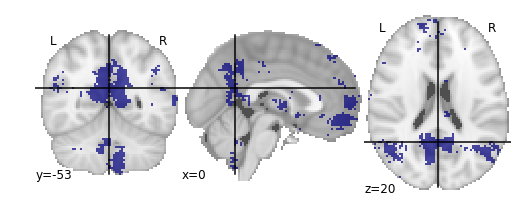

In [9]:
# load mask : Autobiographical
plotting.plot_roi(mask_autobiographicalMemory)
masker_autoBio = NiftiMasker(mask_img = mask_autobiographicalMemory, standardize=True, memory="nilearn_cache", memory_level=1)

In [10]:
def load_scanning_session_matrix_autoBioMask(subject):
    """ Load a scanning session's time-series matrix

    Args:
        subject: subject number (i.e. 'S01')

    Returns:
        a subject's scanning session time-series matrix
    """
    Z_GM = np.load(join(PATH,'data/Z_files',subject + '_Z_autoBioMask.npy'))
    print Z_GM.shape
    return Z_GM

### Leave one subject out cross validation

In [11]:
from sklearn.metrics import accuracy_score
df = pd.DataFrame(columns=['Subject','classification_accuracy','classification_accuracy_reshuffled'])
SUBJECTS = ['S01','S02','S03','S04','S05','S06','S07','S08','S09','S10','S11','S12']

svc = SVC(kernel='linear')
feature_selection = SelectPercentile(f_classif, percentile=PERCENTILE)
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

##### Construct one large matrix [96 movies * 12 subjects,brain_voxels]

In [ ]:
df_multi_subject = pd.DataFrame() # a multi-subject dataframe of [subject_number,onsets,brain_voxels]
for i,s in enumerate(SUBJECTS):
    if s == 'S11':
        RUNS = range(1,6)
    else:
        RUNS = range(1,7)
    print s,
    if not isfile(join(PATH,'data/Z_files',s + '_Z_autoBioMask.npy')):
        apply_niftiMasker_autoBioMask(s,RUNS,masker_autoBio)
        
    single_subject_Z = load_scanning_session_matrix_autoBioMask(s)
    single_subject_onsets = get_onsets(s,RUNS)
    
    df_single_subject = pd.concat([pd.Series([s] * single_subject_onsets.shape[0]),single_subject_onsets['category'],pd.DataFrame(single_subject_Z)],axis = 1)
    df_multi_subject = pd.concat([df_multi_subject,df_single_subject],axis = 0)

In [13]:
single_subject_Z.shape

(96, 13235)

In [14]:
df_multi_subject.shape

(1135, 13237)

In [15]:
df_multi_subject.columns = ['subject'] +df_multi_subject.columns[1:].tolist()

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.externals import joblib
from sklearn.utils import shuffle

np.random.seed(11)

classification_results = pd.DataFrame(columns=['Subject','classification_accuracy','classification_accuracy_reshuffled'])
X = df_multi_subject
y = df_multi_subject['category']
logo = LeaveOneGroupOut()
for i, (train_index, test_index) in enumerate(logo.split(X,y,df_multi_subject['subject'])):
    #print train_index, test_index
    X_train = df_multi_subject.iloc[train_index,2:]
    y_train = df_multi_subject.iloc[train_index,1]
    y_train_reshuffled = shuffle(df_multi_subject.iloc[train_index,1])
    print X_train.shape
    print y_train.shape
    X_test = df_multi_subject.iloc[test_index,2:]
    y_test = df_multi_subject.iloc[test_index,1]
    
    anova_svc.fit(X_train,y_train)
    predictions = anova_svc.predict(X_test)
    classification_accuracy = accuracy_score(y_test,predictions)
    
    anova_svc_reshuffle = Pipeline([('anova', feature_selection), ('svc', svc)])
    anova_svc_reshuffle.fit(X_train,y_train_reshuffled)
    predictions_reshuffled = anova_svc_reshuffle.predict(X_test)
    classification_accuracy_reshuffled = accuracy_score(y_test,predictions_reshuffled)
    
    print classification_accuracy
    classification_results.loc[i] = [SUBJECTS[i],classification_accuracy,classification_accuracy_reshuffled]
    #joblib.dump(anova_svc,'models/' +classification_results['Subject'][i] +'_featSelec.pkl')
classification_results

Ttest_relResult(statistic=6.8246840424451065, pvalue=2.8584960323908213e-05)


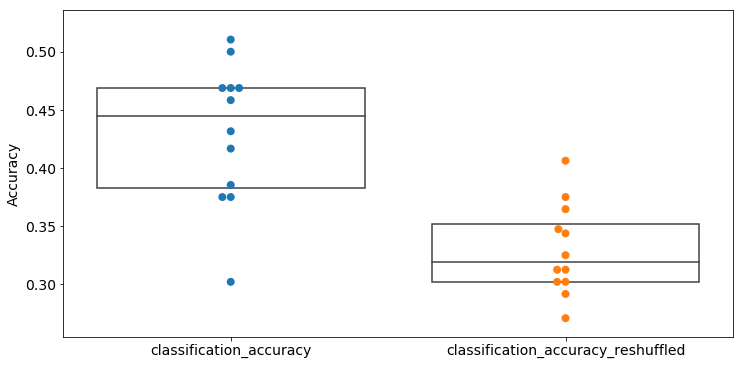

In [17]:
from helper_functions import plot_classification_accuracies
plot_classification_accuracies(classification_results)